## Part 3: BERT classification system for predicting ratings from reviews.

### Importing necessary package

In [2]:
# !pip install tensorflow_text

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

# visualisation
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
 
pyo.init_notebook_mode()  

Output hidden; open in https://colab.research.google.com to view.

### Loading the beauty dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df_beauty = pd.read_json('/content/drive/My Drive/Courses/AML/Assignment01/beauty_products_reviews.json', lines=True)
df_beauty

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5264,5,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-C6B5F7C374'},Amzon Customer,I have genetic undereye darkness. Ive accepted...,Pretty Sweet!!!,1534982400,2,NaN
5265,5,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-7117EE3788'},Amzon Customer,I absolutely love this eye gel.,As advertised,1534982400,NaN,NaN
5266,5,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-BF66BD2F87'},Amzon Customer,The eye gel is easy to apply and I use it morn...,I'm very happy with,1534982400,NaN,NaN
5267,5,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-03868FCB34'},Amzon Customer,Ok this eye gel is good stuff.,Does it's thing!,1534982400,NaN,NaN


### Creating a new dataframe with reviews and rating

In [6]:
reviews_ratings_df = df_beauty[['reviewText', 'overall']]
reviews_ratings_df = reviews_ratings_df.rename(columns = {'reviewText': 'review', 'overall': 'rating'})
reviews_ratings_df

,review,rating
0,As advertised. Reasonably priced,5
1,Like the oder and the feel when I put it on my...,5
2,I bought this to smell nice after I shave. Wh...,1
3,HEY!! I am an Aqua Velva Man and absolutely lo...,5
4,If you ever want to feel pampered by a shampoo...,5
...,...,...
5264,I have genetic undereye darkness. Ive accepted...,5
5265,I absolutely love this eye gel.,5
5266,The eye gel is easy to apply and I use it morn...,5
5267,Ok this eye gel is good stuff.,5


In [7]:
reviews_ratings_df.describe(include = 'all')

,review,rating
count,5264,5269.000000
unique,1363,NaN
top,Great product,NaN
freq,15,NaN
mean,NaN,4.771873
std,NaN,0.743204
min,NaN,1.000000
25%,NaN,5.000000
50%,NaN,5.000000
75%,NaN,5.000000


In [8]:
# dropping rows with null value
reviews_ratings_df = reviews_ratings_df.dropna(how='any',axis=0) 
reviews_ratings_df.isnull().any()

review    False
rating    False
dtype: bool

In [9]:
rating_count = reviews_ratings_df['rating'].value_counts()
(rating_count/sum(rating_count)) * 100

5    88.221884
4     6.306991
1     2.184650
3     2.070669
2     1.215805
Name: rating, dtype: float64

In [10]:
fig = px.bar(rating_count, labels = {'index': 'rating', 'value' : 'count'}, title = 'Plotting Rating Count')

fig.update_traces(marker_line=dict(width=1, color='DarkSlateGray'))
fig.update_layout(showlegend= False)

fig.show(renderer='colab')

Almost 88% of the data has rating of 5. This implies that the data is heavily skewed towards positive ratings.

In [11]:
# creating a balanced dataset

ratings_123 = reviews_ratings_df[reviews_ratings_df['rating'] < 4]
print(ratings_123['rating'].value_counts())
ratings_4_all = reviews_ratings_df[reviews_ratings_df['rating'] == 4]
print(ratings_4_all['rating'].value_counts())
ratings_4 = ratings_4_all.sample(110 , random_state = 74)
print(ratings_4['rating'].value_counts())
ratings_5_all = reviews_ratings_df[reviews_ratings_df['rating'] == 5]
print(ratings_5_all['rating'].value_counts())
ratings_5 = ratings_5_all.sample(110 , random_state = 74)
print(ratings_5['rating'].value_counts())
ratings_balanced = pd.concat((ratings_123, ratings_4, ratings_5))
print(ratings_balanced['rating'].value_counts())

1    115
3    109
2     64
Name: rating, dtype: int64
4    332
Name: rating, dtype: int64
4    110
Name: rating, dtype: int64
5    4644
Name: rating, dtype: int64
5    110
Name: rating, dtype: int64
1    115
4    110
5    110
3    109
2     64
Name: rating, dtype: int64


In [12]:
# splitting the dataset into training and test set (70-30). Taking reviews as x and ratings as y

# unbalanced dataset
x_train_unbalanced, x_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(reviews_ratings_df['review'], reviews_ratings_df['rating'], test_size=0.2,random_state=25, shuffle=True)
print(x_train_unbalanced.shape, y_train_unbalanced.shape)
print(x_test_unbalanced.shape, y_test_unbalanced.shape)


# balanced dataset
x_train_balanced, x_test_balanced, y_train_balanced, y_test_balanced = train_test_split(ratings_balanced['review'], ratings_balanced['rating'], test_size=0.2,random_state=25, shuffle=True)
print(x_train_balanced.shape, y_train_balanced.shape)
print(x_test_balanced.shape, y_test_balanced.shape)

(4211,) (4211,)
(1053,) (1053,)
(406,) (406,)
(102,) (102,)


In [13]:
print(x_train_balanced)
print(y_train_balanced)

4842    I know sandalwood is a more manly scent; but e...
1053                                  One of my favorites
2241    Too expensive for such poor quality. There was...
2296    Wow I was totally hyped to try this shower gel...
3192    This review is for the "Urban Spa Boucle Bath ...
                              ...                        
2198    Very nice shower cap. This cap has ample room ...
3219    The shampoo has the consistency of water, so y...
906     Very good fragrance. A good nature smell rathe...
3124                    Still does a great pre shave job.
3167    These are typical inexpensive spa accessories,...
Name: review, Length: 406, dtype: object
4842    4
1053    5
2241    1
2296    1
3192    4
       ..
2198    4
3219    1
906     5
3124    4
3167    2
Name: rating, Length: 406, dtype: int64


In [14]:
train_count = [0] * 5
test_count = [0] * 5

for i in y_train_balanced:
  train_count[i-1] = train_count[i-1] + 1

for j in y_test_balanced:
  test_count[j-1] = test_count[j-1] + 1

train_count = np.array(train_count)
test_count = np.array(test_count)

print(train_count/train_count.sum() * 100)
print(test_count/test_count.sum() * 100)

[22.66009852 13.05418719 20.68965517 21.42857143 22.16748768]
[22.54901961 10.78431373 24.50980392 22.54901961 19.60784314]


Splitting has happened in a balanced way.

In [15]:
# one-hot encoding of y 

enc = OneHotEncoder()

#unbalanced
y_train_unb = y_train_unbalanced.to_numpy()
y_test_unb = y_test_unbalanced.to_numpy()

#y_train_unbalanced
enc.fit(y_train_unb.reshape(-1,1))
print(f"Categories: {enc.categories_}")
y_train_unb_onehot = enc.transform(y_train_unb.reshape(-1,1)).toarray()
print(y_train_unbalanced)
print(y_train_unb_onehot)

#y_test_unbalanced
print()

enc.fit(y_test_unb.reshape(-1,1))
print(f"Categories: {enc.categories_}")
y_test_unb_onehot = enc.transform(y_test_unb.reshape(-1,1)).toarray()
print(y_test_unbalanced)
print(y_test_unb_onehot)

#balanced
y_train_b = y_train_balanced.to_numpy()
y_test_b = y_test_balanced.to_numpy()


#y_train_unbalanced
enc.fit(y_train_b.reshape(-1,1))
print(f"Categories: {enc.categories_}")
y_train_b_onehot = enc.transform(y_train_b.reshape(-1,1)).toarray()
print(y_train_balanced)
print(y_train_b_onehot)

#y_test_unbalanced
print()

enc.fit(y_test_b.reshape(-1,1))
print(f"Categories: {enc.categories_}")
y_test_b_onehot = enc.transform(y_test_b.reshape(-1,1)).toarray()
print(y_test_balanced[:10])
print(y_test_b_onehot[:10])


Categories: [array([1, 2, 3, 4, 5])]
4104    5
3565    5
517     5
683     5
3783    5
       ..
255     5
2937    5
2193    3
318     5
5257    5
Name: rating, Length: 4211, dtype: int64
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]

Categories: [array([1, 2, 3, 4, 5])]
4405    5
2716    5
2803    5
2120    5
1453    5
       ..
1394    5
3792    5
4480    5
1213    5
935     5
Name: rating, Length: 1053, dtype: int64
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
Categories: [array([1, 2, 3, 4, 5])]
4842    4
1053    5
2241    1
2296    1
3192    4
       ..
2198    4
3219    1
906     5
3124    4
3167    2
Name: rating, Length: 406, dtype: int64
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]

Categories: [array([1, 2, 3, 4, 5])]
4872    4
2660    4
4217    1
3175    2
5044    4
1285  

### Loading the Bert Prepocessor and Base Uncased Encoder 

In [16]:
bert_preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name = 'Preprocessing')
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2", name = 'Encoder')

# bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2", name = 'Encoder')

The Small Bert model has 4 layers, 512 hidden units, and 4 attention head.

### Building the Rating Classifer Model

In [18]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name = 'Text Input Layer')
  preprocessed_text = bert_preprocessor(text_input)
  encoder_outputs = bert_model(preprocessed_text)
  nn = tf.keras.layers.Dropout(0.1, name='Dropout')(encoder_outputs['pooled_output'])
  nn = tf.keras.layers.Dense(5, activation='softmax', name='Classifier')(nn)
  return tf.keras.Model(text_input, nn)
                                    
classifier_model = build_classifier_model()

In [19]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text Input Layer (InputLayer)  [(None,)]            0           []                               
                                                                                                  
 Preprocessing (KerasLayer)     {'input_type_ids':   0           ['Text Input Layer[0][0]']       
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

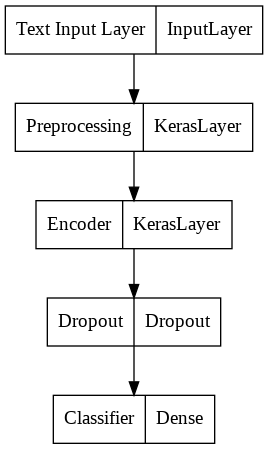

In [20]:
tf.keras.utils.plot_model(classifier_model)

In [21]:
# compiling the model

classifier_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['categorical_accuracy'])

In [22]:
print(x_train_unbalanced.shape, y_train_unb_onehot.shape)

(4211,) (4211, 5)


### Training the Classifier on unbalanced dataset

In [ ]:
# fitting the model
c_model_unb = classifier_model.fit(x = x_train_unbalanced, y = y_train_unb_onehot, batch_size = 64, validation_split = 0.1, epochs = 5)

Epoch 1/5
60/60 [==============================] - 307s 5s/step - loss: 0.5590 - categorical_accuracy: 0.8583 - val_loss: 0.3402 - val_categorical_accuracy: 0.9123
Epoch 2/5
60/60 [==============================] - 300s 5s/step - loss: 0.4399 - categorical_accuracy: 0.8757 - val_loss: 0.3198 - val_categorical_accuracy: 0.9147
Epoch 3/5
60/60 [==============================] - 302s 5s/step - loss: 0.4058 - categorical_accuracy: 0.8773 - val_loss: 0.3033 - val_categorical_accuracy: 0.9147
Epoch 4/5
60/60 [==============================] - 297s 5s/step - loss: 0.3827 - categorical_accuracy: 0.8783 - val_loss: 0.2977 - val_categorical_accuracy: 0.9123
Epoch 5/5
60/60 [==============================] - 298s 5s/step - loss: 0.3635 - categorical_accuracy: 0.8831 - val_loss: 0.2869 - val_categorical_accuracy: 0.9147


In [ ]:
classifier_model.save('/content/drive/My Drive/Courses/AML/Assignment01/bert_model_unbalanced.h5')

In [ ]:
# getting training results

accuracy = c_model_unb.history['categorical_accuracy']
val_accuracy = c_model_unb.history['val_categorical_accuracy']
loss = c_model_unb.history['loss']
val_loss = c_model_unb.history['val_loss']
epochs = range(len(accuracy))

training_df_unb = pd.DataFrame(epochs, columns = ['epochs'])
training_df_unb['acc']= accuracy
training_df_unb['val_acc']= val_accuracy
training_df_unb['loss']= loss
training_df_unb['val_loss']= val_loss

training_df_unb

,epochs,acc,val_acc,loss,val_loss
0,0,0.858274,0.912322,0.559027,0.340222
1,1,0.875693,0.914692,0.439911,0.319753
2,2,0.877276,0.914692,0.405767,0.303319
3,3,0.878332,0.912322,0.382661,0.297708
4,4,0.883083,0.914692,0.363470,0.286921


In [ ]:
# plotting training loss and accuracy vs validation loss and accuracy

fig = px.line(training_df_unb, x = 'epochs', y = training_df_unb.columns[3:5], title = 'Plotting Training Loss Graph', 
              labels = {'value': 'Loss'}, markers = True, width=500, height=300)
fig.show(renderer = 'colab')

fig = px.line(training_df_unb, x = 'epochs', y = training_df_unb.columns[1:3], title = 'Plotting Training Accuracy Graph', 
              labels = {'value': 'Accuracy'}, markers = True, width=500, height=300)

fig.show(renderer = 'colab')

Training loss and accuracy are moving in the same direction but huge disparity between training and validation accuracy. So, the model might be overfitting.

### Testing the Classifier on unbalanced dataset

In [ ]:
results_unb = classifier_model.evaluate(x_test_unbalanced, y_test_unb_onehot)

33/33 [==============================] - 85s 3s/step - loss: 0.3480 - categorical_accuracy: 0.8908


The Classifier on an unbalanced dataset has a testing accuracy of 89%.

In [ ]:
# predicting rating on sample dataset

sample_dataset = [
 'This is not a nice product. I hate it',
 'Awesome Product. Really Good',
 'The product is damaged. I am really dissappointed with the final product.',
 'Worth Buying. I loved it.',
 'I really liked the product. The product is great'
]

(np.argmax(classifier_model.predict(sample_dataset), axis = 1 ) + 1)

array([5, 5, 4, 5, 5])

### Training the classifier on balanced dataset

In [23]:
print(x_train_balanced.shape, y_train_b_onehot.shape)

(406,) (406, 5)


In [24]:
# fitting the model
c_model_b = classifier_model.fit(x = x_train_balanced, y = y_train_b_onehot, batch_size = 64, validation_split = 0.1, epochs = 5) 

Epoch 1/5
6/6 [==============================] - 35s 5s/step - loss: 1.8038 - categorical_accuracy: 0.1699 - val_loss: 1.7497 - val_categorical_accuracy: 0.1463
Epoch 2/5
6/6 [==============================] - 30s 5s/step - loss: 1.6871 - categorical_accuracy: 0.2192 - val_loss: 1.6371 - val_categorical_accuracy: 0.2195
Epoch 3/5
6/6 [==============================] - 29s 5s/step - loss: 1.5566 - categorical_accuracy: 0.2904 - val_loss: 1.6334 - val_categorical_accuracy: 0.2195
Epoch 4/5
6/6 [==============================] - 29s 5s/step - loss: 1.4840 - categorical_accuracy: 0.3342 - val_loss: 1.5968 - val_categorical_accuracy: 0.2683
Epoch 5/5
6/6 [==============================] - 28s 5s/step - loss: 1.4169 - categorical_accuracy: 0.3726 - val_loss: 1.5340 - val_categorical_accuracy: 0.3171


In [36]:
classifier_model.save('/content/drive/My Drive/Courses/AML/Assignment01/bert_model_balanced.h5')

In [25]:
# getting training results

accuracy = c_model_b.history['categorical_accuracy']
val_accuracy = c_model_b.history['val_categorical_accuracy']
loss = c_model_b.history['loss']
val_loss = c_model_b.history['val_loss']
epochs = range(len(accuracy))

training_df_b = pd.DataFrame(epochs, columns = ['epochs'])
training_df_b['acc']= accuracy
training_df_b['val_acc']= val_accuracy
training_df_b['loss']= loss
training_df_b['val_loss']= val_loss

training_df_b

,epochs,acc,val_acc,loss,val_loss
0,0,0.169863,0.146341,1.803808,1.749746
1,1,0.219178,0.219512,1.687136,1.637119
2,2,0.290411,0.219512,1.556643,1.633383
3,3,0.334247,0.268293,1.484036,1.596798
4,4,0.372603,0.317073,1.416917,1.534008


In [26]:
# plotting training loss and accuracy vs validation loss and accuracy

fig = px.line(training_df_b, x = 'epochs', y = training_df_b.columns[3:5], title = 'Plotting Training Loss Graph', 
              labels = {'value': 'Loss'}, markers = True, width=500, height=300)
fig.show(renderer = 'colab')

fig = px.line(training_df_b, x = 'epochs', y = training_df_b.columns[1:3], title = 'Plotting Training Loss Graph', 
              labels = {'value': 'Accuracy'}, markers = True, width=500, height=300)
fig.show(renderer = 'colab')


### Testing the Classifier on balanced dataset


In [27]:
results_b = classifier_model.evaluate(x_test_balanced, y_test_b_onehot)

4/4 [==============================] - 7s 2s/step - loss: 1.3590 - categorical_accuracy: 0.4608


The Bert-based Rating prediction classifier has a testing accuracy of 47%.

In [34]:
sample_dataset = [
 'This is not a nice product. I hate it',
 'Awesome Product. Really Good',
 'The product is damaged. I am really dissappointed with the final product.',
 'Worth Buying. I loved it.',
 'I really liked the product. The product is great'
]

np.argmax(classifier_model.predict(sample_dataset), axis = 1) + 1

array([1, 5, 4, 5, 4])

### In first case, the models suffers from poor dataset which is riddled with duplicate and poor entries. Moreover, the dataset is skewed towards positive ratings. This led to a poor and unreliable model which isn't good at all for predictions.

### In the second case we are using the same dataset but after balancing the dataset, we at least got rid of the skewness. But this resulted into a data set with only about 600 entries which isn't at all sufficient to build a robust and reliable predictor/model.